In [1]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive, infer_discrete, TraceEnum_ELBO, config_enumerate, SVI
from pyro.infer.autoguide import AutoNormal, AutoDelta
from pyro.ops.indexing import Vindex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


In [2]:
initial_probs = torch.tensor([0.5, 0.5])
transition_matrix = torch.tensor([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = torch.tensor([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6], # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: torch.Size([2, 2])
B.shape: torch.Size([2, 6])


In [3]:
hmm = dist.DiscreteHMM(
    initial_logits=torch.logit(initial_probs),
    transition_logits=torch.logit(transition_matrix),
    observation_dist=dist.Categorical(emission_probs),
    duration=100
    )

emission = hmm.sample()

In [4]:
@config_enumerate
def model_2(xs):
    # sample an inital latent state
    z = pyro.sample('z_init', dist.Categorical(initial_probs))
    states = []
    for t, y in pyro.markov(enumerate(xs)):
        # we don't need to add {enumerate: ...} b/c the 
        # @config_enumerate decorator detects discrete dist.
        z = pyro.sample(
            f'z_{t}', 
            dist.Categorical(Vindex(transition_matrix)[..., z, :]),
            )
        states.append(z)
        pyro.sample(
            f"obs_{t}", 
            dist.Categorical(Vindex(emission_probs)[..., z, :]),
            obs=y
            )

    return states

In [207]:
def guide(xs):
    pass

In [ ]:
#we do not care about the global params. in this example (emission and transmission probs.)
hmm_guide = AutoDelta(
    pyro.poutine.block(
        model_2,
        #expose_fn=lambda msg: msg["name"].startswith("z_"))
        # expose="z_init",
        hide_fn=lambda msg: msg["name"].startswith("z_")
        )
    )

optimizer = pyro.optim.Adam({'lr': 0.03})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model_2, hmm_guide, optimizer, loss=elbo)
#elbo.loss(model_2, hmm_guide, emission)

pyro.clear_param_store()

losses = []
for step in range(501):
    loss = svi.step(emission)
    losses.append(loss)

# losses[:10]

In [ ]:
# plt.figure(figsize=(7,3), dpi=100).set_facecolor('white')
# plt.plot(losses)
# plt.xlabel('iters')
# plt.ylabel('loss')
# plt.yscale('log')
# plt.title('Convergence of SVI');

In [50]:
#latent_states = torch.Tensor(elbo.sample_posterior(model_2, guide, emission))

In [ ]:
post_samples = torch.Tensor(
    [infer_discrete(model_2, first_available_dim=-1, temperature=1)(emission) for _ in range(100)]
    )
posterior_samples = {"z": post_samples}
# post_pred = Predictive(model_2, posterior_samples)(emission)

In [92]:
posterior_samples['z'].shape

torch.Size([100, 100])

In [88]:
cnt = 0
samps = {}
for batch in post_samples:
    cnt += 1
    for t, y in enumerate(batch):
        if cnt == 1:
            samps[t] = [y]
        else:
            samps[t].append(y)

probs_loaded = []
for key, val in samps.items():
    probs_loaded.append(sum(val) / len(val))

In [96]:
posterior_samples = torch.Tensor(
    infer_discrete(model_2, first_available_dim=-1, temperature=1)(emission)
)
posterior_samples = {"z": posterior_samples}
post_pred = Predictive(model=model_2, posterior_samples=posterior_samples)(emission)

In [ ]:
# probs_loaded = []
# for key, value in post_pred.items():
#     if 'z_' in key:
#         probs_loaded.append(sum(value) / len(value))

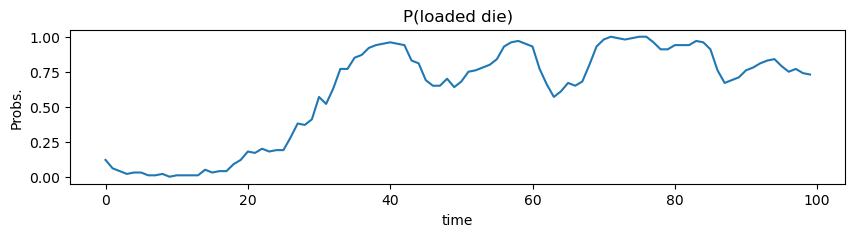

In [89]:
plt.figure(figsize=(10, 2))
plt.plot(
    torch.arange(0, 100),
    probs_loaded
    )
plt.ylabel('Probs.')
plt.xlabel('time')
plt.title('P(loaded die)');

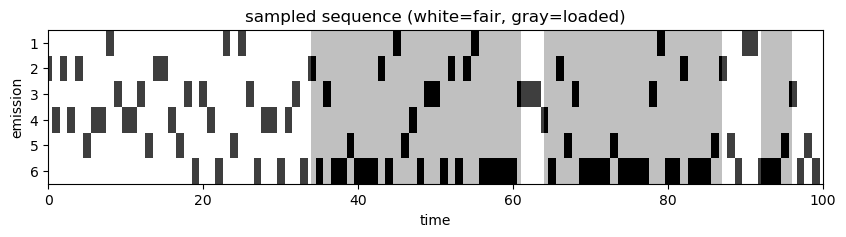

In [97]:
one_hot = torch.nn.functional.one_hot(emission, 6).T

plt.figure(figsize=(10, 2))
plt.imshow(one_hot, aspect="auto", interpolation="none", cmap="Greys")
plt.imshow(
    posterior_samples['z'][None, :], extent=(0, 100, 6-.5, -.5), 
    interpolation="none", aspect="auto", cmap="Greys", alpha=0.25
    )
plt.xlabel("time")
plt.ylabel("emission")
plt.yticks(np.arange(6), np.arange(6) + 1)
plt.title("sampled sequence (white=fair, gray=loaded)");